## DB SCAN (1D)

In [1]:
import sys
if '../' not in sys.path:
    sys.path.append('../')

import seaborn as sns
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.model_selection import ParameterGrid
from matplotlib import pyplot as plt
from jenkspy import JenksNaturalBreaks

from src.clustering import SingleDimensionalClustererFinder, SklearnSingleDimensionalClustererFinder, GeneralClustererFinder
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import MinMaxScaler

In [34]:
data = pd.read_excel("../data/raw/ROS1_all data randomised.xlsx")
series = data["VALUE"].to_numpy()
data.head(3)

,WELL,row,column,VALUE,Well type,CONTROL OUTLIER,CTRL NEG Mean(VALUE),CTRL NEG Standard deviation(VALUE),CTRL NEG Median(VALUE),CTRL POS Mean(VALUE),...,CTRL POS Median(VALUE),CMPD Mean(VALUE),CMPD Standard deviation(VALUE),Z',Z' robust,% ACTIVATION,Z score,ACTIVITY (above 30%),ACTIVITY (Z score above 3),Transfer Status
0,A01,1,1,12123,CMPD,NaN,11282.0,388.181361,11274.5,96504.3125,...,96602.5,11926.059659,2610.13325,0.870037,0.870198,0.986831,0.075452,INACTIVE,Z score below 3,OK
1,A02,1,2,10507,CMPD,NaN,11282.0,388.181361,11274.5,96504.3125,...,96602.5,11926.059659,2610.13325,0.870037,0.870198,-0.909386,-0.543673,INACTIVE,Z score below 3,OK
2,A03,1,3,11176,CMPD,NaN,11282.0,388.181361,11274.5,96504.3125,...,96602.5,11926.059659,2610.13325,0.870037,0.870198,-0.124381,-0.287365,INACTIVE,Z score below 3,OK


### Silhouette metric

In [36]:
DB_scan_params = ParameterGrid({"eps": [0.1, 0.2,0.3, 0.4], "min_samples":[2,3,5]})

DB_scan_clusterer_finder = SklearnSingleDimensionalClustererFinder(
    param_grid=DB_scan_params, 
    scoring_function=metrics.silhouette_score,
    clusterer=DBSCAN()
)

best_DB_scan_prediction = DB_scan_clusterer_finder.cluster_data_series(series, verbose=True)

Params: {'eps': 0.1, 'min_samples': 2} | Score: -0.1832950992609628
Params: {'eps': 0.1, 'min_samples': 3} | Score: -0.7415027833142472
Params: {'eps': 0.1, 'min_samples': 5} | Score: -0.8311958868740931
Params: {'eps': 0.2, 'min_samples': 2} | Score: -0.1832950992609628
Params: {'eps': 0.2, 'min_samples': 3} | Score: -0.7415027833142472
Params: {'eps': 0.2, 'min_samples': 5} | Score: -0.8311958868740931
Params: {'eps': 0.3, 'min_samples': 2} | Score: -0.1832950992609628
Params: {'eps': 0.3, 'min_samples': 3} | Score: -0.7415027833142472
Params: {'eps': 0.3, 'min_samples': 5} | Score: -0.8311958868740931
Params: {'eps': 0.4, 'min_samples': 2} | Score: -0.1832950992609628
Params: {'eps': 0.4, 'min_samples': 3} | Score: -0.7415027833142472
Params: {'eps': 0.4, 'min_samples': 5} | Score: -0.8311958868740931

DONE

Best Score: -0.1832950992609628
Best Params: {'eps': 0.1, 'min_samples': 2}


### Davies-Boulding metric

In [37]:
# As previously, compared with Davies-Boulding metric
negated_davies_boulding = lambda *args, **kwargs: -metrics.davies_bouldin_score(*args, **kwargs)

DB_scan_clusterer_finder_DB = SklearnSingleDimensionalClustererFinder(
    param_grid=DB_scan_params, 
    scoring_function=negated_davies_boulding,
    clusterer=DBSCAN()
)

best_AHC_prediction_DB = DB_scan_clusterer_finder_DB.cluster_data_series(series, verbose=True)

Params: {'eps': 0.1, 'min_samples': 2} | Score: -5.74589488100956
Params: {'eps': 0.1, 'min_samples': 3} | Score: -2.963633139947879
Params: {'eps': 0.1, 'min_samples': 5} | Score: -1.651012110916729
Params: {'eps': 0.2, 'min_samples': 2} | Score: -5.74589488100956
Params: {'eps': 0.2, 'min_samples': 3} | Score: -2.963633139947879
Params: {'eps': 0.2, 'min_samples': 5} | Score: -1.651012110916729
Params: {'eps': 0.3, 'min_samples': 2} | Score: -5.74589488100956
Params: {'eps': 0.3, 'min_samples': 3} | Score: -2.963633139947879
Params: {'eps': 0.3, 'min_samples': 5} | Score: -1.651012110916729
Params: {'eps': 0.4, 'min_samples': 2} | Score: -5.74589488100956
Params: {'eps': 0.4, 'min_samples': 3} | Score: -2.963633139947879
Params: {'eps': 0.4, 'min_samples': 5} | Score: -1.651012110916729

DONE

Best Score: -1.651012110916729
Best Params: {'eps': 0.1, 'min_samples': 5}


## Combine experiment no. 1 and 2

In [38]:
def parse_barcode_col(data):
   data[['Barcode_prefix', 'Barcode_exp', 'Barcode_suffix']] = data['Barcode assay plate'].str.extract(pat='(.{13})([^0-9]*)(.*)') 
   return data

In [39]:
data_ROS1 = pd.read_excel("../data/raw/ROS1_DTT_fanonymised_limited.xlsx")
data_ROS1 = parse_barcode_col(data_ROS1)
# data_ROS1.head(3)

In [40]:
data_ROS2 = pd.read_excel("../data/raw/ROS2_HRP anonymised limited.xlsx")
data_ROS2 = parse_barcode_col(data_ROS2)
# data_ROS2.head(3)

In [41]:
# pd.set_option('display.max_columns', None)
data_all = pd.merge(data_ROS1, data_ROS2, left_on=['DTT  - compound ID', 'Barcode_prefix', 'Barcode_suffix'], right_on = ['HRP - compound ID', 'Barcode_prefix', 'Barcode_suffix'])\
    .rename(columns={'HRP - compound ID':'Compound ID'})[['Compound ID', 'Barcode_prefix', 'Barcode_suffix', 'VALUE_x', 'VALUE_y']]

data_all.head()

,Compound ID,Barcode_prefix,Barcode_suffix,VALUE_x,VALUE_y
0,102092,B1007L2002L03,1,27269,0.104
1,102092,B1007L2002L03,2,27290,0.105
2,102091,B1007L2002L03,1,27128,0.102
3,102091,B1007L2002L03,2,26992,0.111
4,102090,B1007L2002L03,1,27276,0.102


In [42]:
def standarize_column(df, col):
    new_col = col+'_stan'
    df[new_col] = (df[col] - df[col].mean()) / df[col].std()
    return df

In [43]:
# min-max normalization
scaler = MinMaxScaler()
cols_to_norm = ['VALUE_x','VALUE_y']
new_names = ['VALUE_x_norm','VALUE_y_norm']
data_all[new_names] = scaler.fit_transform(data_all[cols_to_norm])
print(data_all.head())

X = data_all[new_names].to_numpy()
# X

   Compound ID Barcode_prefix Barcode_suffix  VALUE_x  VALUE_y  VALUE_x_norm  \
0       102092  B1007L2002L03              1    27269    0.104      0.065126   
1       102092  B1007L2002L03              2    27290    0.105      0.065267   
2       102091  B1007L2002L03              1    27128    0.102      0.064183   
3       102091  B1007L2002L03              2    26992    0.111      0.063273   
4       102090  B1007L2002L03              1    27276    0.102      0.065173   

   VALUE_y_norm  
0      0.026987  
1      0.028486  
2      0.023988  
3      0.037481  
4      0.023988  


In [46]:
DB_scan_clusterer_finder = GeneralClustererFinder(
    param_grid=DB_scan_params, 
    scoring_function=metrics.silhouette_score,
    clusterer=DBSCAN()
)

best_DB_scan_prediction = DB_scan_clusterer_finder.cluster_data_series(X, verbose=True)

Params: {'eps': 0.1, 'min_samples': 2} | Score: 0.9472960615263036
Params: {'eps': 0.1, 'min_samples': 3} | Score: 0.9620831139508913
Params: {'eps': 0.1, 'min_samples': 5} | Score: 0.9620831139508913
Params: {'eps': 0.2, 'min_samples': 2} | Score: 0.9523327050820884
Params: {'eps': 0.2, 'min_samples': 3} | Score: 0.9642110929800247
Params: {'eps': 0.2, 'min_samples': 5} | Score: 0.9642110929800247
Params: {'eps': 0.3, 'min_samples': 2} | Score: 0.9649321901312947
Params: {'eps': 0.3, 'min_samples': 3} | Score: 0.9649321901312947
Params: {'eps': 0.3, 'min_samples': 5} | Score: 0.9646257706208126
Params: {'eps': 0.4, 'min_samples': 2} | Score: 0.9668603343418097
Params: {'eps': 0.4, 'min_samples': 3} | Score: 0.9668603343418097
Params: {'eps': 0.4, 'min_samples': 5} | Score: 0.9668603343418097

DONE

Best Score: 0.9668603343418097
Best Params: {'eps': 0.4, 'min_samples': 2}


In [47]:
DB_scan_clusterer_finder_DB = GeneralClustererFinder(
    param_grid=DB_scan_params, 
    scoring_function=negated_davies_boulding,
    clusterer=DBSCAN()
)

best_DB_scan_prediction_DB = DB_scan_clusterer_finder_DB.cluster_data_series(X, verbose=True)

Params: {'eps': 0.1, 'min_samples': 2} | Score: -0.4532175452294541
Params: {'eps': 0.1, 'min_samples': 3} | Score: -0.83586002748021
Params: {'eps': 0.1, 'min_samples': 5} | Score: -0.83586002748021
Params: {'eps': 0.2, 'min_samples': 2} | Score: -0.5345540534337184
Params: {'eps': 0.2, 'min_samples': 3} | Score: -0.8520073870359169
Params: {'eps': 0.2, 'min_samples': 5} | Score: -0.8520073870359169
Params: {'eps': 0.3, 'min_samples': 2} | Score: -0.3562116288458883
Params: {'eps': 0.3, 'min_samples': 3} | Score: -0.3562116288458883
Params: {'eps': 0.3, 'min_samples': 5} | Score: -0.7461790033234603
Params: {'eps': 0.4, 'min_samples': 2} | Score: -0.30042484963616106
Params: {'eps': 0.4, 'min_samples': 3} | Score: -0.30042484963616106
Params: {'eps': 0.4, 'min_samples': 5} | Score: -0.30042484963616106

DONE

Best Score: -0.30042484963616106
Best Params: {'eps': 0.4, 'min_samples': 2}


c:\Users\agata\anaconda3\envs\data-mining2\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


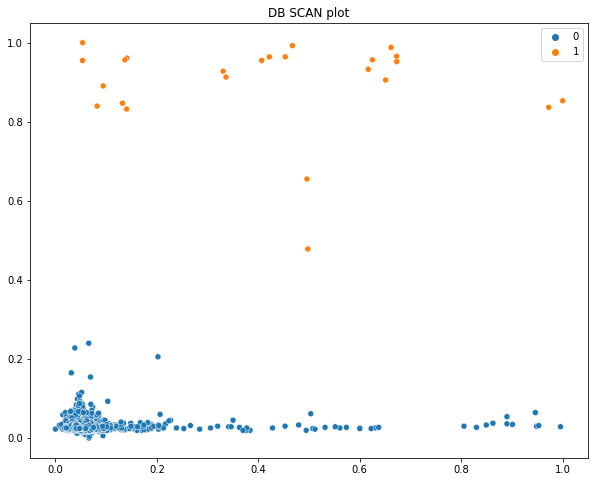

In [49]:
labels = DB_scan_clusterer_finder.cached_best_prediction
plt.figure(figsize=(10, 8))
sns.scatterplot(X[:,0], X[:,1], hue=labels).set_title('DB SCAN plot')
plt.show() 